<a href="https://colab.research.google.com/github/ricardodeazambuja/MultiPose-EdgeTPU-RPI0/blob/main/Compiling_a_tfjs_MultiPoseNet_TFLite_model_to_EdgeTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert tfjs models to run on the EdgeTPU

Based on: https://towardsdatascience.com/optimizing-pose-estimation-on-the-coral-edge-tpu-d331c63cfed

# Converting models from tfjs

In [ ]:
# Library that allows us to convert the TensorFlowJS JSON model format into the TensorFlowLite Flatbuffer
# https://codeburst.io/json-vs-protocol-buffers-vs-flatbuffers-a4247f8bda6f
!sudo pip3 install git+git://github.com/patlevin/tfjs-to-tf --upgrade > /dev/null

  Running command git clone -q git://github.com/patlevin/tfjs-to-tf /tmp/pip-req-build-kxsza5yb


In [ ]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import os
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from pathlib import Path # trying to stop using os.path...

# import tfjs_graph_converter.api as tfjs

In [ ]:
# https://storage.googleapis.com/tfjs-models/
CONFIGS = {
            'resnet50':{
                'float':23,
                'quant1':6,
                'quant2':12,
                'strides': [16, 32]
                },
            'mobilenet':{
                'float': {'050': 1, '075': 2, '100':4},
                'quant1':{'050': 1, '075': 1, '100':1},
                'quant2':{'050': 1, '075': 1, '100':2},
                'strides': [8, 16]
                }
           }

CONFIGS = {
            'mobilenet':{
                'float': {'050': 1},
                'quant1':{'050': 1},
                'quant2':{'050': 1},
                'strides': [16]
                }
           }

save_dir_name = "downloadedModels"
base_uri = "https://storage.googleapis.com/tfjs-models/savedmodel/posenet/"
for model_name, config in CONFIGS.items():
  strides = config['strides']
  file_uris = []
  for key, item in config.items():
    if 'strides' not in key:
      if type(item) == dict:
        multipliers = ['/'+ki for ki in item.keys()]
        shards = [vi for vi in item.values()]
      else:
        multipliers = ['']
        shards = [item]
      for mi,si in zip(multipliers,shards):
        for i in range(1,si+1):
          file_uris.append(model_name + "/" + key + mi + f"/group1-shard{i}of{si}.bin")
        for i in strides:
          file_uris.append(model_name + "/" + key + mi + f"/model-stride{i}.json")

  for file_uri in file_uris:
    uri = base_uri + file_uri
    save_path =  Path(save_dir_name).joinpath(*file_uri.split("/")[0:-1])
    save_path.mkdir(parents=True, exist_ok=True)
    urlretrieve(uri, str(save_path.joinpath(file_uri.split("/")[-1])))
    print(save_path, file_uri)

downloadedModels/mobilenet/float/050 mobilenet/float/050/group1-shard1of1.bin
downloadedModels/mobilenet/float/050 mobilenet/float/050/model-stride16.json
downloadedModels/mobilenet/quant1/050 mobilenet/quant1/050/group1-shard1of1.bin
downloadedModels/mobilenet/quant1/050 mobilenet/quant1/050/model-stride16.json
downloadedModels/mobilenet/quant2/050 mobilenet/quant2/050/group1-shard1of1.bin
downloadedModels/mobilenet/quant2/050 mobilenet/quant2/050/model-stride16.json


In [ ]:
# Here there may be an answer:
# https://github.com/patlevin/tfjs-to-tf/issues/10

# import tfjs_graph_converter.api as tfjs

import os

model_paths = [fi for fi in file_uris if "stride" in fi]
model_path = "downloadedModels/" + model_paths[0]
print(model_path)

downloadedModels/mobilenet/float/050/model-stride16.json


In [ ]:
#
# Let's check what is inside the tensorflow js model
#
import json


with open(model_path) as json_file:
    model_json = json.load(json_file)

In [ ]:
name_list = ['heat', 'offset', 'displacement']

for i in model_json['modelTopology']['node']:
  for name in name_list:
    if name in i['name']:
      print(i['name'], i.keys())

MobilenetV1/offset_2/Conv2D_bias dict_keys(['name', 'op', 'attr'])
MobilenetV1/offset_2/weights dict_keys(['name', 'op', 'attr'])
MobilenetV1/heatmap_2/Conv2D_bias dict_keys(['name', 'op', 'attr'])
MobilenetV1/heatmap_2/weights dict_keys(['name', 'op', 'attr'])
MobilenetV1/displacement_fwd_2/Conv2D_bias dict_keys(['name', 'op', 'attr'])
MobilenetV1/displacement_fwd_2/weights dict_keys(['name', 'op', 'attr'])
MobilenetV1/displacement_bwd_2/Conv2D_bias dict_keys(['name', 'op', 'attr'])
MobilenetV1/displacement_bwd_2/weights dict_keys(['name', 'op', 'attr'])
MobilenetV1/offset_2/BiasAdd/conv dict_keys(['name', 'op', 'input', 'attr'])
MobilenetV1/heatmap_2/BiasAdd/conv dict_keys(['name', 'op', 'input', 'attr'])
MobilenetV1/displacement_fwd_2/BiasAdd/conv dict_keys(['name', 'op', 'input', 'attr'])
MobilenetV1/displacement_bwd_2/BiasAdd/conv dict_keys(['name', 'op', 'input', 'attr'])
MobilenetV1/offset_2/BiasAdd dict_keys(['name', 'op', 'input', 'attr'])
MobilenetV1/heatmap_2/BiasAdd dict_ke

In [ ]:
converted_model_path = "convertedModels/"+"/".join(model_path.split('/')[1:-1])

In [ ]:
%%bash -s "$converted_model_path"
rm -rf $1 # because the command below will complain if the directory already exists...

In [ ]:
%%bash -s "$model_path" "$converted_model_path"

#
# From tfjs-to-tf
#
# Without using the --outputs it will work, but I will not be able
# to change the names (SignatureDef) here because --rename only works with --outputs
tfjs_graph_converter \
    $1 \
    $2 \
    --output_format tf_saved_model  #\
    #--outputs 'MobilenetV1/offset_2/BiasAdd','MobilenetV1/heatmap_2/BiasAdd','MobilenetV1/displacement_fwd_2/BiasAdd','MobilenetV1/displacement_bwd_2/BiasAdd'  #\
    #--rename 'MobilenetV1/offset_2/BiasAdd':offsets,'MobilenetV1/heatmap_2/BiasAdd':heatmaps,'MobilenetV1/displacement_fwd_2/BiasAdd':displacement_fwd,'MobilenetV1/displacement_bwd_2/BiasAdd':displacement_bwd,sub_2:input

TensorFlow.js Graph Model Converter

Graph model:    downloadedModels/mobilenet/float/050/model-stride16.json
Output:         convertedModels/mobilenet/float/050
Target format:  tf_saved_model

Converting.... Done.
Conversion took 0.406s


In [ ]:
%%bash -s "$converted_model_path"
echo $1
ls -lah $1
echo "$1/variables"
ls -lah $1/variables

convertedModels/mobilenet/float/050
total 2.3M
drwxr-xr-x 3 root root 4.0K Jan  8 14:14 .
drwxr-xr-x 3 root root 4.0K Jan  8 14:14 ..
-rw-r--r-- 1 root root 2.3M Jan  8 14:14 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jan  8 14:14 variables
convertedModels/mobilenet/float/050/variables
total 8.0K
drwxr-xr-x 2 root root 4.0K Jan  8 14:14 .
drwxr-xr-x 3 root root 4.0K Jan  8 14:14 ..


In [ ]:
%%bash -s "$converted_model_path"
saved_model_cli show --dir $1 --all
# The input is actually the sub_2 and the outputs have a _2 after their names


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['sub_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: sub_2:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['MobilenetV1/displacement_bwd_2/BiasAdd'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 32)
        name: MobilenetV1/displacement_bwd_2/BiasAdd:0
    outputs['MobilenetV1/displacement_fwd_2/BiasAdd'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 32)
        name: MobilenetV1/displacement_fwd_2/BiasAdd:0
    outputs['MobilenetV1/heatmap_2/BiasAdd'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 17)
        name: MobilenetV1/heatmap_2/BiasAdd:0
    outputs['MobilenetV1/offset_2/BiasAdd'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 34)
        name: Mobi

In [ ]:
#
# Now the converted model will be loaded
#
# https://www.tensorflow.org/guide/saved_model
loaded_model = tf.saved_model.load(converted_model_path)
print(list(loaded_model.signatures.keys()))

infer = loaded_model.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
['serving_default']
((), {'sub_2': TensorSpec(shape=(1, None, None, 3), dtype=tf.float32, name='sub_2')})
{'MobilenetV1/heatmap_2/BiasAdd': <tf.Tensor 'MobilenetV1/heatmap_2/BiasAdd:0' shape=(1, None, None, 17) dtype=float32>, 'MobilenetV1/displacement_fwd_2/BiasAdd': <tf.Tensor 'MobilenetV1/displacement_fwd_2/BiasAdd:0' shape=(1, None, None, 32) dtype=float32>, 'MobilenetV1/offset_2/BiasAdd': <tf.Tensor 'MobilenetV1/offset_2/BiasAdd:0' shape=(1, None, None, 34) dtype=float32>, 'MobilenetV1/displacement_bwd_2/BiasAdd': <tf.Tensor 'MobilenetV1/displacement_bwd_2/BiasAdd:0' shape=(1, None, None, 32) dtype=float32>}


In [ ]:
print("The model has {} trainable variables: {}, ...".format(
          len(loaded_model.signatures['serving_default'].trainable_variables),
          ", ".join([v.name for v in loaded_model.signatures['serving_default'].trainable_variables[:5]])))

The model has 0 trainable variables: , ...


In [ ]:
#
# Visualize the graph
#
# graph = infer.graph
# for node in graph.as_graph_def().node:
#   print(f'{node.input} -> {node.name}')

442368/437445 [==============================] - 0s 0us/step


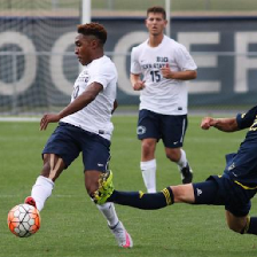

<class 'PIL.Image.Image'> (257, 257, 3) [152 147 131]
(257, 257, 3) [152 147 131]
<class 'numpy.ndarray'> (257, 257, 3) [152. 147. 131.]
(257, 257, 3) [152. 147. 131.]
<class 'numpy.ndarray'> (1, 257, 257, 3) [0.19215691 0.15294123 0.02745104]


In [ ]:
from PIL import ImageOps

#
# Test image
#
file = tf.keras.utils.get_file(
    "soccer.png",
    "https://storage.googleapis.com/tfjs-models/assets/posenet/soccer.png")
img_original = tf.keras.preprocessing.image.load_img(file, target_size=[224, 224])

# Input shape our MobilenetV1 expects
input_shape = (257,257)

# Resize and pad if necessary
img = ImageOps.pad(img_original, input_shape)

display(img)
print(type(img),np.asarray(img).shape, np.asarray(img)[10,10,0:3])
print(np.asarray(img).shape, np.asarray(img)[10,10,0:3])

img_processed = tf.keras.preprocessing.image.img_to_array(img)
print(type(img_processed),img_processed.shape, img_processed[10,10,0:3])
print(img_processed.shape, img_processed[10,10,0:3])

# x = tf.keras.applications.mobilenet.preprocess_input(np.expand_dims(x, axis=0))
img_processed = tf.keras.applications.mobilenet.preprocess_input(img_processed[tf.newaxis,...])
print(type(img_processed),img_processed.shape, img_processed[0,10,10,0:3])

In [ ]:
# Run the inference using the preprocessed image
inference_output_tensor = infer(tf.constant(img_processed))

In [ ]:
# Check the output tensor shapes
for ki in inference_output_tensor.keys():
  print(ki, inference_output_tensor[ki].shape)

MobilenetV1/heatmap_2/BiasAdd (1, 17, 17, 17)
MobilenetV1/displacement_fwd_2/BiasAdd (1, 17, 17, 32)
MobilenetV1/offset_2/BiasAdd (1, 17, 17, 34)
MobilenetV1/displacement_bwd_2/BiasAdd (1, 17, 17, 32)


In [ ]:
#
# Using the results above:
#
output_tensors = {"heatmap": inference_output_tensor['MobilenetV1/heatmap_2/BiasAdd'][0],
                  'offset': inference_output_tensor['MobilenetV1/offset_2/BiasAdd'][0],
                  'displacement_fwd': inference_output_tensor['MobilenetV1/displacement_fwd_2/BiasAdd'][0],
                  'displacement_bwd': inference_output_tensor['MobilenetV1/displacement_bwd_2/BiasAdd'][0]
                  }

In [ ]:
# Shamelessly based on the Javascript version from:
# https://medium.com/tensorflow/real-time-human-pose-estimation-in-the-browser-with-tensorflow-js-7dd0bc881cd5
# 
# OBS 1: 
# Near to zero efforts were made to optimize the code. 
# Could we get 1000x as in https://youtu.be/nxWginnBklU ??? :)
#

from PIL import ImageDraw

MOBILENET_V1_CONFIG = {
    'architecture': 'MobileNetV1',
    'outputStride': 16,
    'multiplier': 0.75,
    'inputResolution': 257
    }

partNames = [
    'nose', 'leftEye', 'rightEye', 'leftEar', 'rightEar', 'leftShoulder',
    'rightShoulder', 'leftElbow', 'rightElbow', 'leftWrist', 'rightWrist',
    'leftHip', 'rightHip', 'leftKnee', 'rightKnee', 'leftAnkle', 'rightAnkle'
]
NUM_KEYPOINTS = len(partNames)
partIds = {k:i for i,k in enumerate(partNames)}

partIds2Names = {i:k for i,k in enumerate(partNames)}

connectedPartNames = [
        ['leftHip', 'leftShoulder'], ['leftElbow', 'leftShoulder'],
        ['leftElbow', 'leftWrist'], ['leftHip', 'leftKnee'],
        ['leftKnee', 'leftAnkle'], ['rightHip', 'rightShoulder'],
        ['rightElbow', 'rightShoulder'], ['rightElbow', 'rightWrist'],
        ['rightHip', 'rightKnee'], ['rightKnee', 'rightAnkle'],
        ['leftShoulder', 'rightShoulder'], ['leftHip', 'rightHip']
    ]
poseChain = [
        ['nose', 'leftEye'], ['leftEye', 'leftEar'], ['nose', 'rightEye'],
        ['rightEye', 'rightEar'], ['nose', 'leftShoulder'],
        ['leftShoulder', 'leftElbow'], ['leftElbow', 'leftWrist'],
        ['leftShoulder', 'leftHip'], ['leftHip', 'leftKnee'],
        ['leftKnee', 'leftAnkle'], ['nose', 'rightShoulder'],
        ['rightShoulder', 'rightElbow'], ['rightElbow', 'rightWrist'],
        ['rightShoulder', 'rightHip'], ['rightHip', 'rightKnee'],
        ['rightKnee', 'rightAnkle']
    ]

partChannels = [
        'left_face',
        'right_face',
        'right_upper_leg_front',
        'right_lower_leg_back',
        'right_upper_leg_back',
        'left_lower_leg_front',
        'left_upper_leg_front',
        'left_upper_leg_back',
        'left_lower_leg_back',
        'right_feet',
        'right_lower_leg_front',
        'left_feet',
        'torso_front',
        'torso_back',
        'right_upper_arm_front',
        'right_upper_arm_back',
        'right_lower_arm_back',
        'left_lower_arm_front',
        'left_upper_arm_front',
        'left_upper_arm_back',
        'left_lower_arm_back',
        'right_hand',
        'right_lower_arm_front',
        'left_hand'
    ];

parentChildrenTuples = [[partIds[parentJoinName], partIds[childJoinName]] for parentJoinName,childJoinName in poseChain]

parentToChildEdges = [i[1] for i in parentChildrenTuples]

childToParentEdges = [i[0] for i in parentChildrenTuples]

def getOffsetPoint(y, x, keypoint, offsets):
    return {
        'y': offsets[y, x, keypoint],
        'x': offsets[y, x, keypoint + NUM_KEYPOINTS]
    }

def getImageCoords(part, outputStride, offsets):
    heatmapY = part['heatmapY']
    heatmapX = part['heatmapX']
    keypoint = part['id']
    _a = getOffsetPoint(heatmapY, heatmapX, keypoint, offsets)
    y = _a['y']
    x = _a['x']
    return {
        'x': part['heatmapX'] * outputStride + x,
        'y': part['heatmapY'] * outputStride + y
    }

def squaredDistance(y1, x1, y2, x2):
    return (x2 - x1)**2 + (y2 - y1)**2
    
def getDisplacement(edgeId, point, displacements):
    numEdges = int(displacements.shape[2] / 2)
    return {
        'y': displacements[point['y'], point['x'], edgeId],
        'x': displacements[point['y'], point['x'], numEdges + edgeId]
    }

def addVectors(a, b):
    return { 'x': a['x'] + b['x'], 'y': a['y'] + b['y'] };

def clamp(n, smallest, largest): 
    return max(smallest, min(n, largest))

def getStridedIndexNearPoint(point, outputStride, height, width):
    return {
        'y': clamp(round(point['y'] / outputStride), 0, height - 1),
        'x': clamp(round(point['x'] / outputStride), 0, width - 1)
    }


def scoreIsMaximumInLocalWindow(keypointId, score, heatmapY, heatmapX, localMaximumRadius, scores):
  height = scores.shape[0]
  width = scores.shape[1]

  xStart = max(heatmapX - localMaximumRadius, 0)
  xEnd = min(heatmapX + localMaximumRadius + 1, width)
  yStart = max(heatmapY - localMaximumRadius, 0)
  yEnd = min(heatmapY + localMaximumRadius + 1, height)

  return (scores[xStart:xEnd, yStart:yEnd, keypointId]).max() < score


def buildPartWithScoreQueue(scoreThreshold, kLocalMaximumRadius=1, scores=None):
  heatmapYs, heatmapXs, keypointIds = np.where(scores > scoreThreshold)
  queue = []
  for heatmapY, heatmapX, keypointId in zip(heatmapYs, heatmapXs, keypointIds):
    score = scores[heatmapY, heatmapX, keypointId]
    if (scoreIsMaximumInLocalWindow(keypointId, score, heatmapY, heatmapX, kLocalMaximumRadius, scores)):
        queue.append({'score': score, 
                      'part': {'heatmapY': heatmapY, 'heatmapX': heatmapX, 'id': keypointId }
                      })
  return queue


def traverseToTargetKeypoint(edgeId, sourceKeypoint, targetKeypointId, scoresBuffer, offsets, outputStride, displacements, offsetRefineStep=None):
    if (offsetRefineStep == None):  offsetRefineStep = 2
    height = scoresBuffer.shape[0]
    width = scoresBuffer.shape[1];
    sourceKeypointIndices = getStridedIndexNearPoint(sourceKeypoint['position'], outputStride, height, width)
    displacement = getDisplacement(edgeId, sourceKeypointIndices, displacements)
    displacedPoint = addVectors(sourceKeypoint['position'], displacement)
    targetKeypoint = displacedPoint
    for i in range(offsetRefineStep):
        targetKeypointIndices = getStridedIndexNearPoint(targetKeypoint, outputStride, height, width)
        offsetPoint = getOffsetPoint(targetKeypointIndices['y'], targetKeypointIndices['x'], targetKeypointId, offsets)
        targetKeypoint = addVectors({
            'x': targetKeypointIndices['x'] * outputStride,
            'y': targetKeypointIndices['y'] * outputStride
        }, { 'x': offsetPoint['x'], 'y': offsetPoint['y'] })
    targetKeyPointIndices = getStridedIndexNearPoint(targetKeypoint, outputStride, height, width)
    score = scoresBuffer[targetKeyPointIndices['y'], targetKeyPointIndices['x'], targetKeypointId]
    return { 'position': targetKeypoint, 'score': score }


def decodePose(root, scores, offsets, outputStride, displacementsFwd, displacementsBwd):
    numParts = scores.shape[2]
    numEdges = len(parentToChildEdges);
    instanceKeypoints = dict(zip(partNames,[None]*numParts))
    rootPart = root['part']
    rootScore = root['score']
    rootPoint = getImageCoords(rootPart, outputStride, offsets)
    instanceKeypoints[partNames[rootPart['id']]] = {
        'score': rootScore,
        'position': rootPoint}

    for edge in range(numEdges)[::-1]:
        sourceKeypointId = partIds2Names[parentToChildEdges[edge]]
        targetKeypointId = partIds2Names[childToParentEdges[edge]]
        if (instanceKeypoints[sourceKeypointId] and (not instanceKeypoints[targetKeypointId])):
            instanceKeypoints[targetKeypointId] = traverseToTargetKeypoint(edge, instanceKeypoints[sourceKeypointId], partIds[targetKeypointId], scores, offsets, outputStride, displacementsBwd)
  
    for edge in range(numEdges):
        sourceKeypointId = partIds2Names[childToParentEdges[edge]]
        targetKeypointId = partIds2Names[parentToChildEdges[edge]]
        if (instanceKeypoints[sourceKeypointId] and (not instanceKeypoints[targetKeypointId])):
            instanceKeypoints[targetKeypointId] = traverseToTargetKeypoint(edge, instanceKeypoints[sourceKeypointId], partIds[targetKeypointId], scores, offsets, outputStride, displacementsFwd)
    
    return instanceKeypoints

def withinNmsRadiusOfCorrespondingPoint(poses, squaredNmsRadius, _a, keypointId):
    x = _a['x']
    y = _a['y']

    for pose in poses:
      keypoints = pose['keypoints']
      correspondingKeypoint = keypoints[partIds2Names[keypointId]]['position']
      if squaredDistance(y, x, correspondingKeypoint['y'], correspondingKeypoint['x']) <= squaredNmsRadius:
        return True
    return False

def getInstanceScore(existingPoses, squaredNmsRadius, instanceKeypoints):
    notOverlappedKeypointScores = 0.0
    for keypointId,ik in enumerate(instanceKeypoints.values()):
        position = ik['position']
        score = ik['score']
        # if (not withinNmsRadiusOfCorrespondingPoint(existingPoses, squaredNmsRadius, position, keypointId)):
        notOverlappedKeypointScores += score

    return notOverlappedKeypointScores/len(instanceKeypoints)

def _sigmoid(z):
  return 1/(1 + np.exp(-z))

def decodeMultiplePoses(scoresBuffer, offsetsBuffer, displacementsFwdBuffer, displacementsBwdBuffer, 
                        outputStride=16, maxPoseDetections=5, scoreThreshold=None, nmsRadius=None, kLocalMaximumRadius=1):
  return _decodeMultiplePoses(_sigmoid(np.asarray(scoresBuffer)), np.asarray(offsetsBuffer), np.asarray(displacementsFwdBuffer), np.asarray(displacementsBwdBuffer), 
                              outputStride, maxPoseDetections, scoreThreshold, nmsRadius, kLocalMaximumRadius)
def _decodeMultiplePoses(scoresBuffer, offsetsBuffer, displacementsFwdBuffer, displacementsBwdBuffer, outputStride, 
                         maxPoseDetections, scoreThreshold, nmsRadius, kLocalMaximumRadius):
  if scoreThreshold == None: scoreThreshold = 0.5
  if nmsRadius == None: nmsRadius = 20
  poses = []
  queue = buildPartWithScoreQueue(scoreThreshold, kLocalMaximumRadius, scoresBuffer)
  squaredNmsRadius = nmsRadius * nmsRadius;
  while (len(poses) < maxPoseDetections) and len(queue):
    root = queue.pop()
    rootImageCoords = getImageCoords(root['part'], outputStride, offsetsBuffer)
    if (withinNmsRadiusOfCorrespondingPoint(poses, squaredNmsRadius, rootImageCoords, root['part']['id'])):
      continue
    keypoints = decodePose(root, scoresBuffer, offsetsBuffer, outputStride, displacementsFwdBuffer, displacementsBwdBuffer)
    score = getInstanceScore(poses, squaredNmsRadius, keypoints)
    poses.append({ 'keypoints': keypoints, 'score': score })
  return poses

def draw_pose(pose, img, threshold=0.5, marker_color='green', color='yellow', marker_size=5, thickness=2):
    # Resize and pad if necessary, the same way done for the inference
    img = ImageOps.pad(img, input_shape)
    draw = ImageDraw.Draw(img)

    for p1, p2 in poseChain:
        if (pose[p1]['score'] < threshold) or (pose[p2]['score'] < threshold): continue
        draw.line((pose[p1]['position']['x'], pose[p1]['position']['y'], pose[p2]['position']['x'], pose[p2]['position']['y']), fill=color, width=thickness)

    for label, keypoint in pose.items():
      if keypoint['score'] < threshold: continue
      draw.ellipse((int(keypoint['position']['x']-marker_size/2), 
                    int(keypoint['position']['y']-marker_size/2), 
                    int(keypoint['position']['x']+marker_size/2), 
                    int(keypoint['position']['y']+marker_size/2)), fill=marker_color)
      
    return img

In [ ]:
# Possible options for the profiler cell magic %%prun -s <option>:
# calls (call count)
# cumulative (cumulative time)
# cumtime (cumulative time)
# file (file name)
# filename (file name)
# module (file name)
# ncalls (call count)
# pcalls (primitive call count)
# line (line number)
# name (function name)
# nfl (name/file/line)
# stdname (standard name)
# time (internal time)
# tottime (internal time)

# %%prun -s cumulative 

poses = decodeMultiplePoses(output_tensors['heatmap'], 
                            output_tensors['offset'], 
                            output_tensors['displacement_fwd'], 
                            output_tensors['displacement_bwd'])

In [ ]:
poses[0]

{'keypoints': {'leftAnkle': {'position': {'x': 120.53896141052246,
    'y': 233.12932205200195},
   'score': 0.6219748},
  'leftEar': {'position': {'x': 93.91834425926208, 'y': 43.86604404449463},
   'score': 0.9794449},
  'leftElbow': {'position': {'x': 86.18980407714844, 'y': 99.26020455360413},
   'score': 0.8488595},
  'leftEye': {'position': {'x': 81.75203728675842, 'y': 41.26613807678223},
   'score': 0.9886464},
  'leftHip': {'position': {'x': 92.23954176902771, 'y': 132.06526803970337},
   'score': 0.99276954},
  'leftKnee': {'position': {'x': 92.64324045181274, 'y': 189.43856620788574},
   'score': 0.9736789},
  'leftShoulder': {'position': {'x': 104.47566986083984,
    'y': 67.93566966056824},
   'score': 0.99359965},
  'leftWrist': {'position': {'x': 61.1285924911499, 'y': 117.16503381729126},
   'score': 0.94247437},
  'nose': {'position': {'x': 75.99638271331787, 'y': 45.36677312850952},
   'score': 0.995427},
  'rightAnkle': {'position': {'x': 120.6833872795105, 'y': 233.

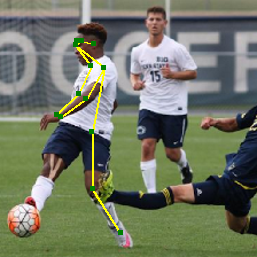

0.7413156128981534


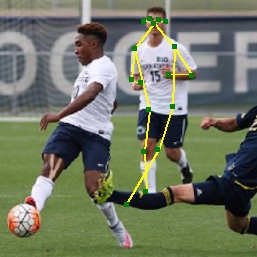

0.9278723492341883


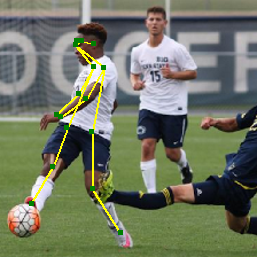

0.8181722146623275


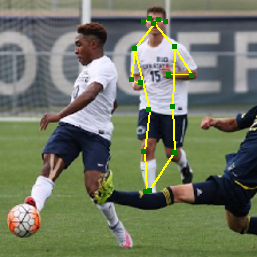

0.9334535388385549


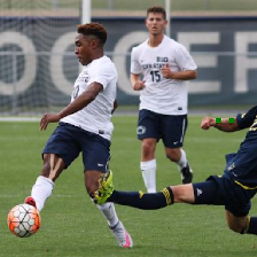

0.20531466934720383


In [ ]:
for pose in poses:
  display(draw_pose(pose['keypoints'], img_original.copy()))
  print(pose['score'])

Install the EdgeTPU compiler:

In [ ]:
%%bash
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

sudo apt-get update > /dev/null

sudo apt-get install edgetpu-compiler > /dev/null

OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0  21456      0 --:--:-- --:--:-- --:--:-- 21456
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


## https://www.tensorflow.org/lite/convert#python_api

In [ ]:
tf.__version__

'2.4.0'

In [ ]:
ls convertedModels/mobilenet/float/050

saved_model.pb  variables/


In [ ]:
tflite_model_path = "_".join(model_path.split('.')[0].split('/'))+'.tflite'
tflite_model_path

'downloadedModels_mobilenet_float_050_model-stride16.tflite'

In [ ]:
# It's necessary to specify the input shape if it's undefined (-1)
#
# https://github.com/tensorflow/tensorflow/issues/35736#issuecomment-573814435
# Load the SavedModel.
saved_model_obj = tf.saved_model.load(export_dir=converted_model_path)

# Load the specific concrete function from the SavedModel.
concrete_func = saved_model_obj.signatures['serving_default']

# Set the shape of the input in the concrete function.
concrete_func.inputs[0].set_shape([1, input_shape[0], input_shape[1], 3])

# Convert the model to a TFLite model.
converter =  tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

# # Convert the model.
# # This option only works if the model has an input shape that is not -1 in any dimension
# converter = tf.lite.TFLiteConverter.from_saved_model(converted_model_path,signature_keys=['serving_default'],)

data_source = img_processed.flatten()
# https://www.tensorflow.org/lite/performance/post_training_quantization
def representative_dataset():
    for _ in range(10):
        # yield [tf.random.normal((1,257,257,3))] 
        # yield [img_processed] # this is the test image...
        yield [img_processed+tf.random.normal((1,257,257,3),stddev=0.1)] # this is the test image + noise
        # yield [tf.random.normal((1,257,257,3),mean=0,stddev=data_source.std())] # this is the test image + noise
        # you should really use a dataset here...
        # or read more about natural images: 
        # http://www.cs.toronto.edu/~zemel/Courses/CS2541/Papers/rudReview.pdf

# It's not possible to convert (quantization) to int/uint without the representative_dataset
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# If I select tf.uint8, edgetpu compiler adds some QUANTIZE ops
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8


# https://www.tensorflow.org/lite/performance/post_training_integer_quant
# https://www.tensorflow.org/lite/performance/post_training_quantization
# https://github.com/google-coral/edgetpu/issues/25
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]


tflite_model = converter.convert() # quantized model

# Save the model.
print(tflite_model_path)
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

# The message:
# INFO:tensorflow:Saver not created because there are no variables in the graph to restore
# doesn't mean it didn't work...

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
downloadedModels_mobilenet_float_050_model-stride16.tflite


In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
tflite_interpreter.allocate_tensors()

In [ ]:
tflite_interpreter.get_input_details()

[{'dtype': numpy.int8,
  'index': 0,
  'name': 'sub_2_int8',
  'quantization': (0.01062560174614191, -2),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.0106256], dtype=float32),
   'zero_points': array([-2], dtype=int32)},
  'shape': array([  1, 257, 257,   3], dtype=int32),
  'shape_signature': array([  1, 257, 257,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
tflite_interpreter.get_output_details()

[{'dtype': numpy.int8,
  'index': 90,
  'name': 'MobilenetV1/displacement_bwd_2/BiasAdd_int8',
  'quantization': (0.6587493419647217, 46),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.65874934], dtype=float32),
   'zero_points': array([46], dtype=int32)},
  'shape': array([ 1, 17, 17, 32], dtype=int32),
  'shape_signature': array([ 1, 17, 17, 32], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.int8,
  'index': 91,
  'name': 'MobilenetV1/displacement_fwd_2/BiasAdd_int8',
  'quantization': (0.5399798154830933, -42),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([0.5399798], dtype=float32),
   'zero_points': array([-42], dtype=int32)},
  'shape': array([ 1, 17, 17, 32], dtype=int32),
  'shape_signature': array([ 1, 17, 17, 32], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.int8,
  'index': 92,
  'name': 'MobilenetV1/heatmap_2/BiasAdd_int8',
  'quantization': (0.07224702835083008, 44),
  'quantizatio

In [ ]:
tflite_interpreter._get_ops_details()

[{'index': 0,
  'inputs': array([ 0, 28, 25], dtype=int32),
  'op_name': 'CONV_2D',
  'outputs': array([63], dtype=int32)},
 {'index': 1,
  'inputs': array([63, 29, 24], dtype=int32),
  'op_name': 'DEPTHWISE_CONV_2D',
  'outputs': array([64], dtype=int32)},
 {'index': 2,
  'inputs': array([64, 30, 23], dtype=int32),
  'op_name': 'CONV_2D',
  'outputs': array([65], dtype=int32)},
 {'index': 3,
  'inputs': array([65, 31, 22], dtype=int32),
  'op_name': 'DEPTHWISE_CONV_2D',
  'outputs': array([66], dtype=int32)},
 {'index': 4,
  'inputs': array([66, 32, 21], dtype=int32),
  'op_name': 'CONV_2D',
  'outputs': array([67], dtype=int32)},
 {'index': 5,
  'inputs': array([67, 33, 20], dtype=int32),
  'op_name': 'DEPTHWISE_CONV_2D',
  'outputs': array([68], dtype=int32)},
 {'index': 6,
  'inputs': array([68, 34, 19], dtype=int32),
  'op_name': 'CONV_2D',
  'outputs': array([69], dtype=int32)},
 {'index': 7,
  'inputs': array([69, 35, 18], dtype=int32),
  'op_name': 'DEPTHWISE_CONV_2D',
  'outpu

In [ ]:
%%bash -s "$tflite_model_path"
edgetpu_compiler -s $1

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 343 ms.

Input model: downloadedModels_mobilenet_float_050_model-stride16.tflite
Input size: 750.45KiB
Output model: downloadedModels_mobilenet_float_050_model-stride16_edgetpu.tflite
Output size: 804.95KiB
On-chip memory used for caching model parameters: 714.50KiB
On-chip memory remaining for caching model parameters: 7.15MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 31
Operation log: downloadedModels_mobilenet_float_050_model-stride16_edgetpu.log

Operator                       Count      Status

CONV_2D                        18         Mapped to Edge TPU
DEPTHWISE_CONV_2D              13         Mapped to Edge TPU


In [ ]:
final_filename = tflite_model_path.split('.')[0]+"_edgetpu"

In [ ]:
%%bash -s "$final_filename"
cat $1.log

Edge TPU Compiler version 15.0.340273435
Input: downloadedModels_mobilenet_float_050_model-stride16.tflite
Output: downloadedModels_mobilenet_float_050_model-stride16_edgetpu.tflite

Operator                       Count      Status

CONV_2D                        18         Mapped to Edge TPU
DEPTHWISE_CONV_2D              13         Mapped to Edge TPU


## Visualize tflite model 
Following https://towardsdatascience.com/optimizing-pose-estimation-on-the-coral-edge-tpu-d331c63cfed

In [ ]:
!wget -O posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite https://github.com/google-coral/project-posenet/blob/master/models/mobilenet/posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite?raw=true
!wget -O posenet_mobilenet_v1_075_353_481_quant_decoder.tflite https://github.com/google-coral/project-posenet/blob/master/models/mobilenet/posenet_mobilenet_v1_075_353_481_quant_decoder.tflite?raw=true 

--2021-01-10 16:39:16--  https://github.com/google-coral/project-posenet/blob/master/models/mobilenet/posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/google-coral/project-posenet/raw/master/models/mobilenet/posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite [following]
--2021-01-10 16:39:16--  https://github.com/google-coral/project-posenet/raw/master/models/mobilenet/posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/google-coral/project-posenet/master/models/mobilenet/posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite [following]
--2021-01-10 16:39:17--  https://raw.githubusercontent.com/google-

In [ ]:
ls

posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite  sample_data/
posenet_mobilenet_v1_075_353_481_quant_decoder.tflite


In [ ]:
!git clone https://github.com/ricardodeazambuja/tensorflow.git 

Cloning into 'tensorflow'...
remote: Enumerating objects: 1062771, done.
remote: Total 1062771 (delta 0), reused 0 (delta 0), pack-reused 1062771
Receiving objects: 100% (1062771/1062771), 640.45 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (865277/865277), done.
Checking out files: 100% (24068/24068), done.


In [ ]:
!python tensorflow/tensorflow/lite/tools/visualize.py downloadedModels_mobilenet_float_050_model-stride16.tflite model.html

2021-01-10 18:08:04.067310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
from IPython.display import HTML
with open('model.html','r') as f:
  display(HTML(f.read()))

In [ ]:
%%bash
sudo apt-add-repository ppa:hnakamur/flatbuffers
sudo apt update
sudo apt install -y flatbuffers-compiler > /dev/null

In [ ]:
%%bash
# Converts from TFLITE to JSON
SCHEMA=tensorflow/tensorflow/lite/schema/schema.fbs
flatc -t --strict-json --defaults-json  ${SCHEMA} -- downloadedModels_mobilenet_float_050_model-stride16.tflite

In [ ]:
ls

downloadedModels_mobilenet_float_050_model-stride16.json
downloadedModels_mobilenet_float_050_model-stride16.tflite
model.html
posenet_mobilenet_v1_075_353_481_quant_decoder_edgetpu.tflite
posenet_mobilenet_v1_075_353_481_quant_decoder.json
posenet_mobilenet_v1_075_353_481_quant_decoder.tflite
sample_data/
tensorflow/


In [ ]:
import json

INPUT_MODEL = 'downloadedModels_mobilenet_float_050_model-stride16.json'

# Load model
model = json.load(open(INPUT_MODEL))

In [ ]:
model['operator_codes']

[{'builtin_code': 'CONV_2D', 'deprecated_builtin_code': 3, 'version': 3},
 {'builtin_code': 'DEPTHWISE_CONV_2D',
  'deprecated_builtin_code': 4,
  'version': 3},
 {'builtin_code': 'QUANTIZE', 'deprecated_builtin_code': 114, 'version': 1},
 {'builtin_code': 'DEQUANTIZE', 'deprecated_builtin_code': 6, 'version': 2}]

In [ ]:
model['subgraphs'][0]['tensors']

[{'buffer': 1,
  'is_variable': False,
  'name': 'sub_2_int8',
  'quantization': {'details_type': 0,
   'max': [1.372047],
   'min': [-1.42544],
   'quantized_dimension': 0,
   'scale': [0.010971],
   'zero_point': [2]},
  'shape': [1, 257, 257, 3],
  'type': 'INT8'},
 {'buffer': 2,
  'is_variable': False,
  'name': 'Const_10',
  'quantization': {'details_type': 0,
   'quantized_dimension': 0,
   'scale': [6.2e-05,
    0.000111,
    3.1e-05,
    0.000114,
    5.8e-05,
    0.000128,
    6.8e-05,
    4e-05,
    2.3e-05,
    7.4e-05,
    0.000101,
    2.1e-05,
    8.2e-05,
    2.7e-05,
    3.8e-05,
    0.000123,
    0.000106,
    7.8e-05,
    3.3e-05,
    0.000112,
    8.8e-05,
    3.7e-05,
    3e-05,
    5.8e-05,
    4.2e-05,
    0.000121,
    3.2e-05,
    7.3e-05,
    0.000126,
    4.1e-05,
    2.4e-05,
    4.6e-05,
    5.1e-05,
    0.000157,
    1.9e-05,
    5.7e-05,
    5.3e-05,
    4.9e-05,
    6e-05,
    5.4e-05,
    8.5e-05,
    0.000122,
    2.7e-05,
    7.9e-05,
    4.6e-05,
    

In [ ]:
%debug

> /usr/local/lib/python3.6/dist-packages/flatbuffers/encode.py(26)Get()
     24 def Get(packer_type, buf, head):
     25     """ Get decodes a value at buf[head] using `packer_type`. """
---> 26     return packer_type.unpack_from(memoryview_type(buf), head)[0]
     27 
     28 

ipdb> head
168430090
ipdb> buf
bytearray(b'\n\n\n\n\n\n<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8">\n  <link rel="dns-prefetch" href="https://github.githubassets.com">\n  <link rel="dns-prefetch" href="https://avatars0.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars1.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars2.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://avatars3.githubusercontent.com">\n  <link rel="dns-prefetch" href="https://github-cloud.s3.amazonaws.com">\n  <link rel="dns-prefetch" href="https://user-images.githubusercontent.com/">\n\n\n\n  <link crossorigin="anonymous" media="all" integrity="sha512-BSy

## Backup everything!

In [ ]:
!tar -cvf multipose_edgetpu.tar.gz /content/

tar: Removing leading `/' from member names
/content/
/content/.config/
/content/.config/gce
/content/.config/logs/
/content/.config/logs/2020.12.21/
/content/.config/logs/2020.12.21/17.29.09.326092.log
/content/.config/logs/2020.12.21/17.28.32.541165.log
/content/.config/logs/2020.12.21/17.28.53.747819.log
/content/.config/logs/2020.12.21/17.29.09.888329.log
/content/.config/logs/2020.12.21/17.28.47.180010.log
/content/.config/logs/2020.12.21/17.28.10.224796.log
/content/.config/.last_opt_in_prompt.yaml
/content/.config/configurations/
/content/.config/configurations/config_default
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_update_check.json
/content/.config/config_sentinel
/content/.config/active_config
/content/.config/.metricsUUID
/content/downloadedModels_mobilenet_float_050_model-stride16_edgetpu.log
/content/downloadedModels_mobilenet_float_050_model-stride16_edgetpu.tflite
/content/downloadedModels/
/content/downloadedModels/mobilenet/
/content/downloadedM

In [ ]:
ls -lah

total 254M
drwxr-xr-x 1 root root 4.0K Jan  7 13:36 ./
drwxr-xr-x 1 root root 4.0K Jan  7 13:14 ../
drwxr-xr-x 1 root root 4.0K Dec 21 17:29 .config/
drwxr-xr-x 3 root root 4.0K Jan  7 13:24 convertedModels/
drwxr-xr-x 4 root root 4.0K Jan  7 13:17 downloadedModels/
-rw-r--r-- 1 root root  355 Jan  7 13:28 downloadedModels_mobilenet_float_050_model-stride16_edgetpu.log
-rw-r--r-- 1 root root 677K Jan  7 13:28 downloadedModels_mobilenet_float_050_model-stride16_edgetpu.tflite
-rw-r--r-- 1 root root 752K Jan  7 13:26 downloadedModels_mobilenet_float_050_model-stride16.tflite
-rw-r--r-- 1 root root 253M Jan  7 13:36 multipose_edgetpu.tar.gz
drwxr-xr-x 1 root root 4.0K Dec 21 17:29 sample_data/
